### Librerías

In [14]:
import cv2
import torch
import easyocr
import pytesseract
import pandas as pd
from ultralytics import YOLO
import time

### Vídeo

In [ ]:
# CONFIGURACIÓN
video_input = "test.mp4"           # Ruta del video de entrada
video_output = "resultados/resultado.mp4"     # Video con resultados
csv_output = "csv_resultados/resultados.csv"      # CSV de salida

# Ruta al ejecutable de Tesseract
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'

# Inicializar OCR (inglés → mejor para texto alfanumérico)
reader_easy = easyocr.Reader(['en'], gpu=True)

# Cargar modelos YOLO
modelo_vehiculos = YOLO("yolo11n.pt").to('cuda')
modelo_matriculas = YOLO("best.pt").to('cuda')

# CONFIGURAR VIDEO
cap = cv2.VideoCapture(video_input)
if not cap.isOpened():
    print("Error: no se puede abrir el video")
    exit()

fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(video_output, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

resultados = []
frame_id = 0

# PROCESAMIENTO DE FRAMES
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Detección y tracking de vehículos
    pred = modelo_vehiculos.track(frame, persist=True)[0]

    for obj in pred.boxes:
        x1, y1, x2, y2 = map(int, obj.xyxy[0])
        tipo = modelo_vehiculos.names[int(obj.cls[0])]
        conf = float(obj.conf[0])
        track_id = int(obj.id[0]) if hasattr(obj, 'id') else -1

        matricula_easy = ""
        matricula_tesseract = ""
        time_easy = 0
        time_tesseract = 0

        # Dibujar caja del vehículo
        color = (0, 255, 0) if tipo.lower() == "person" else (255, 0, 0)
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame, f"{tipo} ID:{track_id}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Solo procesar coches
        if tipo.lower() == "car":
            roi_car = frame[y1:y2, x1:x2]
            if roi_car.size > 0:
                pred_matricula = modelo_matriculas.predict(roi_car, conf=0.3)
                matricula_roi = None
                placa_coords = None

                if pred_matricula:
                    for pm in pred_matricula:
                        if pm.boxes:
                            for bbox, conf_m in zip(pm.boxes.xyxy, pm.boxes.conf):
                                if conf_m > 0.4:
                                    mx1, my1, mx2, my2 = map(int, bbox)
                                    matricula_roi = roi_car[my1:my2, mx1:mx2]
                                    placa_coords = (mx1, my1, mx2, my2)
                                    break
                        if matricula_roi is not None:
                            break

                # OCR (EasyOCR + Tesseract)
                if matricula_roi is not None and placa_coords is not None:
                    mx1, my1, mx2, my2 = placa_coords

                    # --- PREPROCESAMIENTO ---
                    roi_gray = cv2.cvtColor(matricula_roi, cv2.COLOR_BGR2GRAY)
                    roi_gray = cv2.resize(roi_gray, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)
                    roi_gray = cv2.GaussianBlur(roi_gray, (3, 3), 0)

                    # Binarización + inversión si es necesario
                    _, roi_thresh = cv2.threshold(roi_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                    if roi_thresh.mean() < 127:
                        roi_thresh = cv2.bitwise_not(roi_thresh)

                    # --- EASY-OCR ---
                    start_easy = time.time()
                    res_easy = reader_easy.readtext(roi_thresh)
                    end_easy = time.time()
                    if res_easy:
                        best_text = ""
                        best_conf = 0
                        for (bbox_e, text, conf_e) in res_easy:
                            if conf_e > best_conf and len(text) >= 4:
                                best_text = text
                                best_conf = conf_e
                        matricula_easy = ''.join([c for c in best_text.upper() if c.isalnum() or c == ' ']).strip()
                    time_easy = end_easy - start_easy

                    # --- TESSERACT ---
                    start_tess = time.time()
                    custom_config = r'--oem 3 --psm 8 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 '
                    matricula_tesseract = pytesseract.image_to_string(
                        roi_thresh, config=custom_config
                    ).strip().upper()
                    matricula_tesseract = ''.join([c for c in matricula_tesseract if c.isalnum() or c == ' ']).strip()
                    end_tess = time.time()
                    time_tesseract = end_tess - start_tess

                    # --- ELECCIÓN DEL MEJOR RESULTADO ---
                    if len(matricula_tesseract) >= len(matricula_easy):
                        texto_final = matricula_tesseract
                    else:
                        texto_final = matricula_easy

                    # --- DIBUJAR MATRÍCULA ---
                    if texto_final:
                        cv2.rectangle(frame, (x1 + mx1, y1 + my1), (x1 + mx2, y1 + my2), (0, 0, 255), 2)
                        cv2.putText(frame, texto_final, (x1 + mx1, y1 + my1 - 5),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        # GUARDAR RESULTADO FRAME A FRAME
        resultados.append({
            "frame": frame_id,
            "tipo": tipo,
            "conf": conf,
            "id": track_id,
            "x1": x1, "y1": y1, "x2": x2, "y2": y2,
            "matricula_easy": matricula_easy,
            "matricula_tesseract": matricula_tesseract,
            "time_easy": time_easy,
            "time_tesseract": time_tesseract
        })

    # Escribir frame procesado en el video
    out.write(frame)
    frame_id += 1

# GUARDAR CSV Y FINALIZAR
df = pd.DataFrame(resultados)
df.to_csv(csv_output, index=False, sep=";")

cap.release()
out.release()
print("Procesamiento finalizado. Video y CSV generados correctamente.")


### Imágenes

In [ ]:
import cv2
import pytesseract
import easyocr
import pandas as pd
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt
from difflib import SequenceMatcher

In [ ]:
# Ruta al ejecutable de Tesseract
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'

# Inicializar OCR (en inglés para matrículas alfanuméricas)
reader_easy = easyocr.Reader(['en'], gpu=True)

# Cargar modelos YOLO
modelo_vehiculos = YOLO("yolo11n.pt").to('cuda')
modelo_matriculas = YOLO("best.pt").to('cuda')

# Carpeta con las imágenes
carpeta_imagenes = "imagenes"  
resultados_csv = "resultados/resultados_matriculas.csv"

# Crear lista para guardar resultados
resultados_globales = []

def procesar_imagen(image_path):
    base_name = os.path.basename(image_path)
    nombre_real, ext = os.path.splitext(base_name)
    frame = cv2.imread(image_path)

    if frame is None:
        print(f"Error al abrir la imagen: {image_path}")
        return None

    # Detección de vehículos
    pred = modelo_vehiculos.track(frame, persist=True)[0]

    # Variables para almacenar OCR
    matricula_easy = ""
    matricula_tesseract = ""

    for obj in pred.boxes:
        tipo = modelo_vehiculos.names[int(obj.cls[0])]

        # Solo procesar coches
        if tipo.lower() == "car":
            x1, y1, x2, y2 = map(int, obj.xyxy[0])
            roi_car = frame[y1:y2, x1:x2]

            if roi_car.size == 0:
                continue

            # Detección de matrícula dentro del coche
            pred_matricula = modelo_matriculas.predict(roi_car, conf=0.3)
            matricula_roi = None

            for pm in pred_matricula:
                if pm.boxes:
                    for bbox, conf_m in zip(pm.boxes.xyxy, pm.boxes.conf):
                        if conf_m > 0.4:
                            mx1, my1, mx2, my2 = map(int, bbox)
                            matricula_roi = roi_car[my1:my2, mx1:mx2]
                            break
                if matricula_roi is not None:
                    break

            if matricula_roi is not None:
                # --- Preprocesamiento ---
                roi_gray = cv2.cvtColor(matricula_roi, cv2.COLOR_BGR2GRAY)
                roi_gray = cv2.resize(roi_gray, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)
                roi_gray = cv2.GaussianBlur(roi_gray, (3, 3), 0)
                _, roi_thresh = cv2.threshold(roi_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                if roi_thresh.mean() < 127:
                    roi_thresh = cv2.bitwise_not(roi_thresh)

                # --- EasyOCR ---
                res_easy = reader_easy.readtext(roi_thresh)
                if res_easy:
                    best_text = ""
                    best_conf = 0
                    for (_, text, conf_e) in res_easy:
                        if conf_e > best_conf and len(text) >= 4:
                            best_text = text
                            best_conf = conf_e
                    matricula_easy = ''.join([c for c in best_text.upper() if c.isalnum() or c == ' ']).strip()

                # --- Tesseract ---
                custom_config = r'--oem 3 --psm 8 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
                matricula_tesseract = pytesseract.image_to_string(
                    roi_thresh, config=custom_config
                ).strip().upper()
                matricula_tesseract = ''.join([c for c in matricula_tesseract if c.isalnum() or c == ' ']).strip()

    # Devolver los resultados
    return {
        "imagen": base_name,
        "matricula_easyocr": matricula_easy,
        "matricula_tesseract": matricula_tesseract,
        "matricula_real": nombre_real
    }


# Procesar todas las imágenes en la carpeta
imagenes = [os.path.join(carpeta_imagenes, f) for f in os.listdir(carpeta_imagenes)
             if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

print(f"🔍 Procesando {len(imagenes)} imágenes...")

for img in imagenes:
    resultado = procesar_imagen(img)
    if resultado:
        resultados_globales.append(resultado)

# Crear y guardar el CSV
df = pd.DataFrame(resultados_globales)
df.to_csv(resultados_csv, index=False, sep=";")
print(f"✅ CSV generado: {resultados_csv}")


#### Métricas

📊 RESULTADOS OCR
Imágenes procesadas: 60
Exactitud (EasyOCR): 1.67%
Exactitud (Tesseract): 11.67%
Similitud media (EasyOCR): 61.24%
Similitud media (Tesseract): 54.60%


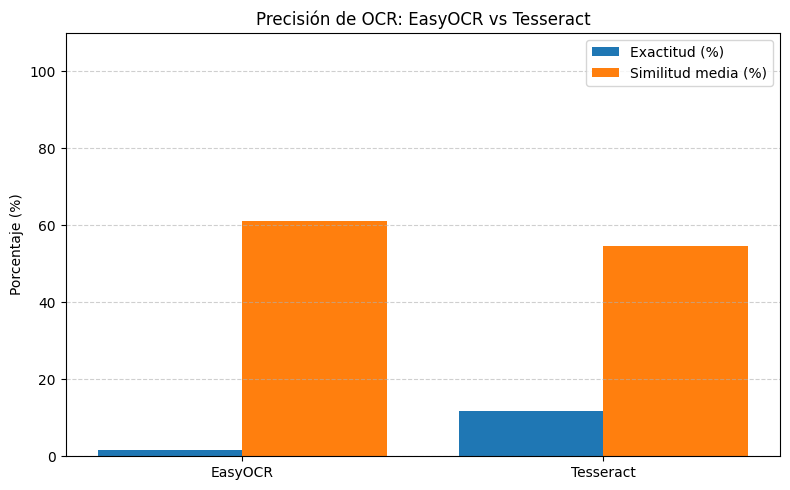

✅ Gráfica guardada en: graficas_resultados\precision_ocr.png


In [ ]:
# === 1. CARGAR CSV ===
df = pd.read_csv("resultados_matriculas.csv", sep=";")

# === 2. FUNCIÓN DE SIMILITUD ===
def similarity(a, b):
    return SequenceMatcher(None, a, b).ratio()

# === 3. CÁLCULO DE MÉTRICAS ===
exact_easy = 0
exact_tess = 0
similarities_easy = []
similarities_tess = []

for _, row in df.iterrows():
    real = str(row["matricula_real"]).strip().upper()
    easy = str(row["matricula_easyocr"]).strip().upper()
    tess = str(row["matricula_tesseract"]).strip().upper()
    
    if real == easy:
        exact_easy += 1
    if real == tess:
        exact_tess += 1

    similarities_easy.append(similarity(real, easy))
    similarities_tess.append(similarity(real, tess))

# === 4. CÁLCULOS FINALES ===
total = len(df)
accuracy_easy = exact_easy / total * 100
accuracy_tess = exact_tess / total * 100

mean_sim_easy = sum(similarities_easy) / total * 100
mean_sim_tess = sum(similarities_tess) / total * 100

# === 5. MOSTRAR RESULTADOS ===
print("📊 RESULTADOS OCR")
print(f"Imágenes procesadas: {total}")
print(f"Exactitud (EasyOCR): {accuracy_easy:.2f}%")
print(f"Exactitud (Tesseract): {accuracy_tess:.2f}%")
print(f"Similitud media (EasyOCR): {mean_sim_easy:.2f}%")
print(f"Similitud media (Tesseract): {mean_sim_tess:.2f}%")

# === 6. CREAR DATAFRAME PARA GRAFICAR ===
data = {
    "Modelo": ["EasyOCR", "Tesseract"],
    "Exactitud (%)": [accuracy_easy, accuracy_tess],
    "Similitud media (%)": [mean_sim_easy, mean_sim_tess]
}
df_metrics = pd.DataFrame(data)

# === 7. GRAFICAR RESULTADOS ===
plt.figure(figsize=(8,5))
x = range(len(df_metrics))

# Barras para cada métrica
plt.bar([i - 0.2 for i in x], df_metrics["Exactitud (%)"], width=0.4, label="Exactitud (%)")
plt.bar([i + 0.2 for i in x], df_metrics["Similitud media (%)"], width=0.4, label="Similitud media (%)")

plt.xticks(x, df_metrics["Modelo"])
plt.title("Precisión de OCR: EasyOCR vs Tesseract")
plt.ylabel("Porcentaje (%)")
plt.ylim(0, 110)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# === 8. GUARDAR LA GRÁFICA ===
os.makedirs("resultados", exist_ok=True)

ruta_grafica = os.path.join("resultados", "precision_ocr.png")

plt.savefig(ruta_grafica, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Gráfica guardada en: {ruta_grafica}")